In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

import time
import matplotlib.pyplot as plt

import SelfAI

### Reading the Data

In [2]:
df = pd.read_csv('Weather Sats.csv')
df.head()

,Date,Hour,Temperature,Wet Temperature,Dew point Temperature,Relative humidity,wind speed,Wind Direction (Degrees)
0,01/04/2010,2:00,13.6,10.8,8,69,2.5,110
1,01/04/2010,5:00,12.2,10.1,7.9,75,3,110
2,01/04/2010,8:00,16.5,12.9,9.4,63,1,320
3,01/04/2010,11:00,19.7,15.4,11.9,61,3.5,240
4,01/04/2010,14:00,20.9,16.1,12.3,58,3,310


### Adding a Column to Describe if it's Day or Night (AM/PM)

In [3]:
# removing the ':00' prefix from the Hour 
df['Hour'] = df['Hour'].str[:-3].astype(int)

In [4]:
# adding a AM/PM column to distinguish between day and night temps
df['AMPM'] = np.where(df['Hour'] < 12, 'am', 'pm')

In [5]:
df.head()

,Date,Hour,Temperature,Wet Temperature,Dew point Temperature,Relative humidity,wind speed,Wind Direction (Degrees),AMPM
0,01/04/2010,2,13.6,10.8,8,69,2.5,110,am
1,01/04/2010,5,12.2,10.1,7.9,75,3,110,am
2,01/04/2010,8,16.5,12.9,9.4,63,1,320,am
3,01/04/2010,11,19.7,15.4,11.9,61,3.5,240,am
4,01/04/2010,14,20.9,16.1,12.3,58,3,310,pm


In [6]:
df.columns

Index(['Date', 'Hour', 'Temperature', 'Wet Temperature',
       'Dew point Temperature', 'Relative humidity', 'wind speed',
       'Wind Direction (Degrees)', 'AMPM'],
      dtype='object')

### Separate into Categorical and Contineous Variables

In [7]:
cont_col = ['Wet Temperature','Dew point Temperature','Relative humidity','wind speed','Wind Direction (Degrees)']
cat_col = ['Hour','AMPM']
label_col = ['Temperature']

In [8]:
# replacing all '-' ocurences with 0 
# df = df.replace('-',0)
print(len(df))
for col in cont_col:
    df = df[~df[col].str.contains('-')]
print(len(df))

28714
27455


In [9]:
df = SelfAI.define_type(df, cat_col, 'category')
df = SelfAI.define_type(df, cont_col, 'float')
df[label_col] = df[label_col].astype(float)

### Calculating the mean temperature for each hour of the day to fill the missing temperature columns

In [10]:
meanTemp = df.groupby('Hour').agg({'Temperature' : np.mean})
meanTemp

,Temperature
Hour,
2,20.412880
5,19.412868
8,21.412547
11,23.420712
14,23.838802
17,23.103401
20,22.167461
23,21.392418


In [11]:
# df['Temperature'] = df['Temperature'].replace(0,meanTemp)
# for ind in df.index: 
#     if df['Temperature'][ind] == 0:
#         df['Temperature'][ind] = (meanTemp['Temperature'][df['Hour'][ind]])

### Stacking categorical, contineous and labels and turning them into tensors

In [12]:
df.dtypes

Date                          object
Hour                        category
Temperature                  float64
Wet Temperature              float64
Dew point Temperature        float64
Relative humidity            float64
wind speed                   float64
Wind Direction (Degrees)     float64
AMPM                        category
dtype: object

In [13]:
cat_stack = SelfAI.stack_cols(df, cat_col, torch.int64, cat=1)
cont_stack = SelfAI.stack_cols(df, cont_col, torch.float)
labels = SelfAI.stack_cols(df, label_col, torch.float)

In [14]:
# torch.tensor(df[label_col].values, dtype=torch.float).reshape(-1,1)

In [15]:
cat_stack.shape

torch.Size([27455, 2])

In [16]:
cont_stack.shape

torch.Size([27455, 5])

In [17]:
labels.shape

torch.Size([27455, 1])

### Creating embedding sizes list

In [18]:
cat_szs = [len(df[col].cat.categories) for col in cat_col]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(8, 4), (2, 1)]

### Creating a Tabular Model

In [19]:
class TabularWeatherModel(nn.Module):
    
    def __init__(self, emb_szs, num_cont, out_size, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.embeds_drop = nn.Dropout(p)
        
        self.bn_cont = nn.BatchNorm1d(num_cont)

        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        num_input = n_emb + num_cont
        
        for i in layers:
            layerlist.append(nn.Linear(num_input,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            num_input = i
        layerlist.append(nn.Linear(layers[-1], out_size))
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embeds_drop(x)
            
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        
        return x

In [20]:
WeatherModel = TabularWeatherModel(emb_szs, cont_stack.shape[1], 1, [200,100,50], p=0.4)

In [21]:
WeatherModel

TabularWeatherModel(
  (embeds): ModuleList(
    (0): Embedding(8, 4)
    (1): Embedding(2, 1)
  )
  (embeds_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

### Define loss function and optimizer

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(WeatherModel.parameters(), lr=0.001)

In [23]:
# split the data into train and test sets
[conts_train, conts_test, cats_train, cats_test, labels_train, labels_test] = SelfAI.create_sets(cont_stack, cat_stack, labels, 20000)

In [24]:
len(conts_train)

16000

In [25]:
labels_test

tensor([[14.7000],
        [17.2000],
        [17.2000],
        ...,
        [24.0000],
        [27.1000],
        [29.2000]])

In [26]:
len(cats_train)

16000

### Train the model on the given data and print&plot results

In [27]:
import time 
start_time = time.time()

epochs = 1000
losses = []

for i in range(epochs):
    i+=1
    
    labels_pred = WeatherModel(cats_train, conts_train)
    loss = criterion(labels_pred, labels_train)
    
    losses.append(loss)
    
    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print(f'epoch: {i:3}  loss: {loss.item():10.8f}') 
print(f'\nTraining Time: {(time.time() - start_time )/60}')

epoch:   1  loss: 508.22219849
epoch: 101  loss: 10.81920338
epoch: 201  loss: 1.65345466
epoch: 301  loss: 0.60734606
epoch: 401  loss: 0.33251452
epoch: 501  loss: 0.21660233
epoch: 601  loss: 0.16121705
epoch: 701  loss: 0.13165137
epoch: 801  loss: 0.11736880
epoch: 901  loss: 0.09867706
epoch: 1000  loss: 0.08800764

Training Time: 3.974868913491567


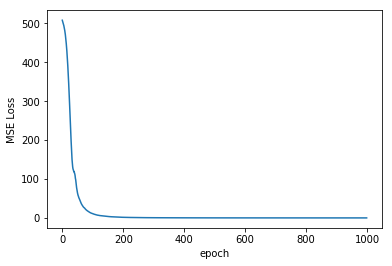

In [28]:
plt.plot(range(epochs), losses)
plt.ylabel('MSE Loss')
plt.xlabel('epoch');

### Evaluate the model on the test set

In [29]:
with torch.no_grad():
    labels_val = WeatherModel(cats_test, conts_test)
    loss = criterion(labels_test, labels_val)
print(loss)    

tensor(0.3387)


In [30]:
diffList = []
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(1200):
    diff = np.abs(labels_val[i].item()-labels_test[i].item())
    diffList.append(diff)
    print(f'{i+1:2}. {labels_val[i].item():8.4f} {labels_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.  15.1995  14.7000   0.4995
 2.  17.6124  17.2000   0.4124
 3.  17.3265  17.2000   0.1265
 4.  13.6022  13.6000   0.0022
 5.  12.8374  13.1000   0.2626
 6.  15.4794  15.1000   0.3794
 7.  14.9885  14.8000   0.1885
 8.  14.9270  14.3000   0.6270
 9.  13.8921  13.4000   0.4921
10.  14.1593  14.2000   0.0407
11.  12.1688  12.7000   0.5312
12.  13.8453  13.8000   0.0453
13.  14.2315  14.7000   0.4685
14.  12.7328  12.4000   0.3328
15.  11.8153  11.2000   0.6153
16.  11.0932  10.5000   0.5932
17.  11.6117  10.9000   0.7117
18.  12.1440  11.3000   0.8440
19.  14.1054  13.3000   0.8054
20.  14.3326  14.0000   0.3326
21.  14.1734  14.3000   0.1266
22.  13.7778  12.9000   0.8778
23.  13.5743  12.5000   1.0743
24.  11.5869  11.4000   0.1869
25.  10.8664  10.1000   0.7664
26.  12.0800  11.9000   0.1800
27.  18.6961  18.6000   0.0961
28.  18.1840  17.8000   0.3840
29.  15.4334  15.0000   0.4334
30.  13.7475  13.5000   0.2475
31.  12.0242  12.2000   0.1758
32.  11.

827.  22.1263  21.6000   0.5263
828.  21.5631  21.2000   0.3631
829.  21.5575  20.9000   0.6575
830.  18.6259  18.5000   0.1259
831.  23.4375  22.8000   0.6375
832.  23.6087  23.2000   0.4087
833.  24.8227  24.3000   0.5227
834.  22.7914  22.3000   0.4914
835.  22.0574  21.4000   0.6574
836.  21.3946  20.9000   0.4946
837.  20.7185  20.3000   0.4185
838.  18.7886  18.3000   0.4886
839.  24.1704  23.5000   0.6704
840.  23.8462  23.4000   0.4462
841.  24.3557  23.7000   0.6557
842.  23.0550  22.5000   0.5550
843.  22.6178  22.1000   0.5178
844.  22.7656  21.9000   0.8656
845.  21.2926  20.8000   0.4926
846.  19.9851  19.6000   0.3851
847.  25.3986  25.1000   0.2986
848.  25.8714  25.7000   0.1714
849.  27.4765  26.8000   0.6765
850.  28.0750  27.8000   0.2750
851.  24.0777  23.6000   0.4777
852.  23.9899  23.4000   0.5899
853.  22.1207  21.8000   0.3207
854.  22.1829  21.9000   0.2829
855.  23.8812  23.1000   0.7812
856.  24.8639  24.2000   0.6639
857.  24.5787  24.1000   0.4787
858.  23

In [31]:
averageDiff = sum(diffList)/len(diffList)

In [32]:
# the average difference between predicted and actual temps in test set
averageDiff

0.532826832930247